## Load data and initialize path

In [1]:
import src.helper_func as hf
import numpy as np
import os, math
import diplib as dip
from matplotlib import pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.ndimage import white_tophat

from skimage.filters import threshold_otsu, threshold_niblack, threshold_sauvola, threshold_triangle
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Data load
data_07022022 = os.path.join('.', 'data', '07022022_data') # First dataset
data_04042022 = os.path.join('.', 'data', '04042022_data') # Second dataset

images, labels = hf.load_tifdata(data_07022022, classes=3, label=True)
# images, labels = hf.load_tifdata(data_04042022, classes=2, label=True, width=768, height=768)

DIPlib -- a quantitative image analysis library
Version 3.1.0 (Sep 24 2021)
For more information see https://diplib.org
Loaded (100) images from .\data\07022022_data


## Diplib implementation of method 

In [2]:
verboseprint = lambda verbose: print if verbose else lambda *a, **k: None
verboseshow = lambda verbose, x, y='': x.Show(y) if verbose else None

def classify_image_part(image, height, width, tensor_sigma=3,  method='IP', method_param={"gaussian_tensor": 21, "inflection_points": 1}, verbose=False):
    """
    Image classification by structure tensor, where image are cut into small part and each part is classify separatly. \n
    parameters \n
        image -> image \n
        height, width -> height, width  of image \n
        tensor_sigma (default 3) -> size of window for ST \n
        method (default IP) -> method for classfication decision, enum 'TH', 'IP', 'RL' \n
        method_param (default for RL) -> parameters for method \n
        verbose (default False) -> show original image, parameters, angle image, threshold image, threshold curve/histogram, print classification results \n
    return \n
         classification_result -> 0 - insulator, 1 - metal \n
    """
    # Cut image into small images 
    crop_images = []
    h = math.floor(image.shape[0] / height)
    w = math.floor(image.shape[1] / width)
    for x in range(0, h):
        for y in range(0, w):
            crop_images.append(image[x*height: (x*height) + height, y*width: (y*width) + width])
    
    verboseprint(verbose)("Original image:")
    verboseshow(verbose, dip.Image(image))

    # Classify each part of image separatly
    classification_result = []
    for index, image in enumerate(crop_images):
        clf = classify_image(image, tensor_sigma=tensor_sigma, method=method, method_param=method_param, verbose=verbose)

        verboseprint(verbose)(f"Classification result for image part={index} --> {clf[0]}")
        verboseshow(verbose, dip.Image(image))
        
        classification_result.append({index: clf[0]})
    return classification_result


def threshold_based(coherence_abs, threshold, classification_border, threshold_algo, verbose):
    """
    Classification method based on thresholding image \n
    parameters \n
        coherence_abs -> coherence array \n
        verbose -> print information about process \n
        threshold_algo -> thresholding algo, available (threshold_sauvola, threshold_triangle, threshold_niblack) or None if only apply threhsolding \n
        threshold -> threshold value if threshold_algo is None \n
        classification_border -> final border which will classify image into metal/vias \n
    return \n
        classification result 0 if image is vias or -1 
    """
    # Apply threshold on coherence
    if threshold_algo == None:
        coherence_image = np.where(coherence_abs > threshold, 1, 0)
    elif threshold_algo == 'threshold_sauvola':
        coherence_image = coherence_abs < threshold_sauvola(coherence_abs, window_size=25)
    elif threshold_algo == 'threshold_triangle':
        coherence_image = coherence_abs < threshold_triangle(coherence_abs)
    elif threshold_algo == 'threshold_niblack':
        coherence_image = coherence_abs > threshold_niblack(coherence_abs, window_size=25, k=0.8)

    thershold_image = dip.Image(coherence_image)
    verboseprint(verbose)('[+] Thershold image:')
    verboseshow(verbose, thershold_image)

    # Classify by coherence_image and classification_border
    ones = np.count_nonzero(coherence_image == 1)
    zeros = np.count_nonzero(coherence_image == 0)
    percent = (zeros / (zeros + ones))

    verboseprint(verbose)(f"Ones {ones} Zeros {zeros} Percent {percent*100}% {1 if percent > classification_border else 0}")
    if percent > classification_border:
        verboseprint(verbose)("[1] Classification --> On image is metal <--")
        return -1
    else:
        verboseprint(verbose)("[0] Classification --> On image is vias (insulator) <--")
        return 0


def raising_lowering_based(coherence_histogram, gaussian_sigma, verbose):
    """
    Classification method based on monotony of histogram curve \n
    parameters \n
        coherence_histogram -> histogram of coherence \n
        gaussian_sigma -> size of window for Gaussian filter \n
        verbose -> print information about process \n
    return \n
        classification result 0 if image is vias or -1
    """
    y = coherence_histogram[0]
    y = y / np.max(y)
    # Blur histogram curve with gaussian filter
    yhat = gaussian_filter(y, gaussian_sigma)

    # Compute estimate of 1. derivative 
    der = np.gradient(yhat)
    # Sum of positive (func increasing) and negative (func decreasing)
    positive = np.sum(der > 0)
    negative = np.sum(der < 0)

    if verbose:
        plt.plot(y, 'r', label='Original histogram curve')
        plt.plot(yhat, 'b', label='Blurred histogram curve')
        plt.show()
        plt.plot(der / np.max(der), 'y',
                 label='First Derivative (scaled)')
        plt.legend(bbox_to_anchor=(1.55, 1.0))
        plt.show()

    verboseprint(verbose)(f"Positive {positive} Negative {negative} -> {0 if negative > positive else 1}")
    if positive > negative:
        verboseprint(verbose)("[1] Classification --> On image is metal <--")
        return -1
    else:
        verboseprint(verbose)("[0] Classification --> On image is vias (insulator) <--")
        return 0


def inflection_point_based(coherence_histogram, gaussian_sigma, inflection_points, verbose):
    """
    Classification method based on finding Inflection point \n
    parameters \n
        coherence_histogram -> histogram of coherence \n
        gaussian_sigma -> size of window for Gaussian filter \n
        inflection_points -> number of inflection points to classify as metal \n
        verbose -> print information about process \n
    return \n
        classification result 0 if image is vias or -1
    """
    y = coherence_histogram[0]
    y = y / np.max(y)
    # Blur histogram curve with gaussian filter
    yhat = gaussian_filter(y, gaussian_sigma)

    # Compute estimate of 2. derivative and find inflection points
    der_2 = np.gradient(np.gradient(yhat))

    # Get count of inflection point
    infls = np.where(np.diff(np.sign(der_2)))[0]
    if verbose:
        plt.title("Curves with inflection points")
        plt.plot(y, 'r', label='Original histogram curve')
        plt.plot(yhat, 'b', label='Blurred histogram curve')
        plt.plot(der_2 / np.max(der_2), 'y',
                 label='Second Derivative (scaled)')
        for i, infl in enumerate(infls, 1):
            plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
        plt.legend(bbox_to_anchor=(1.55, 1.0))
        plt.show()

    verboseprint(verbose)(f"Inflection points {len(infls)} {1 if len(infls) > inflection_points else 0}")
    if len(infls) > inflection_points:
        verboseprint(verbose)("[1] Classification --> On image is metal <--")
        return -1
    else:
        verboseprint(verbose)(
            "[0] Classification --> On image is vias (insulator) <--")
        return 0


def classify_image(image, tensor_sigma=3, method="RL", method_param={"gaussian_tensor": 47}, verbose=False):
    """ Image classification by structure tensor\n
        parameters \n
            image -> image to classify \n
            tensor_sigma (default 3) -> size of window for ST \n
            method (default IP) -> method for classfication decision, enum 'TH', 'IP', 'RL' \n
            method_param (default for RL) -> parameters for method \n
            verbose (default False) -> show original image, parameters, angle image, threshold image, threshold curve/histogram, print classification results \n
        return \n
            classification_result -> 0 - insulator, 1 - metal \n
            (coherence(histogram, bin_edges), max, min) -> curve/histogram of angles after ST \n
    """
    coherence_histogram = ()

    # Load image
    dip_image = dip.Image(image)

    # Verbose show image
    verboseprint(verbose)('\n[+] --------------------------CLASSIFY BY STRUCTURE TENSOR-----------------------------')
    verboseprint(verbose)(f'[+] Classifying with method={method}, method_param={method_param}')
    verboseprint(verbose)('[+] Original image:')
    verboseshow(verbose, dip_image)

    # Compute StructureTensor
    image_gradient = dip.Gradient(dip_image)
    I = image_gradient * dip.Transpose(image_gradient)
    structure_tensor = dip.Gauss(I, tensor_sigma)
    eigenvalues, eigenvectors = dip.EigenDecomposition(structure_tensor)

    # Verbose show image after ST
    angle = dip.Angle(eigenvectors.TensorColumn(0))
    verboseprint(verbose)('[+] StructureTensor orientation image:')
    verboseshow(verbose, angle, 'orientation')

    # Compute coherence
    coherence = ((eigenvalues(0) - eigenvalues(1)) / (eigenvalues(0) + eigenvalues(1))) ** 2
    coherence_abs = np.abs(np.array(coherence))
    dip.Image(coherence).Show()

    # Coherence histogram
    image_hist = coherence_abs
    max = np.max(image_hist)
    min = np.min(image_hist)
    coherence_histogram = np.histogram(image_hist, bins=256, range=(min, max))

    #### --> method based classfication <-- ####
    if method == "TH":
        result_TH = threshold_based(coherence_abs, method_param['threshold'], method_param['classification_border'], method_param['threshold_algo'], verbose)
        if result_TH == 0:
            return 0, (coherence_histogram, max, min)
    if method == "IP":
        result_IP = inflection_point_based(coherence_histogram, method_param['gaussian_sigma'], method_param['inflection_points'], verbose)
        if result_IP == 0:
            return 0, (coherence_histogram, max, min)
    if method == "RL":
        result_RL = raising_lowering_based(coherence_histogram, method_param['gaussian_sigma'], verbose)
        if result_RL == 0:
            return 0, (coherence_histogram, max, min)

    return 1, (coherence_histogram, max, min)

method_params = {
    "TH": {"threshold": 0.0, "classification_border": 0.66, 'threshold_algo': 'threshold_sauvola'},
    "IP": {"gaussian_sigma": 47, "inflection_points": 1},
    "RL": {"gaussian_sigma": 47}
}

--------------------------------------------------------------------------------------------------------------------------------------

## Prediction on dataset

In [9]:
true_values = []
prediction_ip = []
prediction_th = []
prediction_rl = []

# Prediction on every image
for image in images:
    img = image['img']
    img = white_tophat(img, 7) # Applied white tophat transformation

    cls_ip = classify_image(img, tensor_sigma=5, method="IP", method_param=method_params['IP'], verbose=False)[0] # Inflection point based method
    cls_rl = classify_image(img, tensor_sigma=5, method="RL", method_param=method_params['RL'], verbose=False)[0] # Monotony based method
    cls_th = classify_image(img, tensor_sigma=5, method="TH", method_param=method_params['TH'], verbose=False)[0] # Thresholding based method

    true_values.append(1 if image['Y'] > 0 else 0)
    prediction_th.append(1 if cls_th > 0 else 0)
    prediction_ip.append(1 if cls_ip > 0 else 0)
    prediction_rl.append(1 if cls_rl > 0 else 0)

# Print metrics of classification (accuracy, f1_score)
print('prediction_th', accuracy_score(true_values, prediction_th), f1_score(true_values, prediction_th), precision_score(true_values, prediction_th), recall_score(true_values, prediction_th))
print('prediction_ip', accuracy_score(true_values, prediction_ip), f1_score(true_values, prediction_ip), precision_score(true_values, prediction_th), recall_score(true_values, prediction_th))
print('prediction_rl', accuracy_score(true_values, prediction_rl), f1_score(true_values, prediction_rl), precision_score(true_values, prediction_th), recall_score(true_values, prediction_th))

prediction_th 1.0 1.0 1.0 1.0
prediction_ip 0.6190476190476191 0.3846153846153846 1.0 1.0
prediction_rl 0.9761904761904762 0.975609756097561 1.0 1.0


In [4]:
# Print result of classification
print('Label\n',labels)
print('prediction_ip\n', prediction_ip)
print('prediction_th\n', prediction_th)
print('prediction_rl\n', prediction_rl)

Label
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
prediction_ip
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
prediction_th
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
prediction_rl
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,

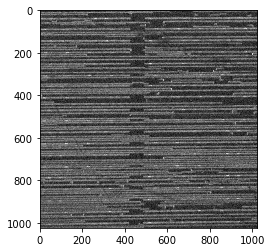


[+] --------------------------CLASSIFY BY STRUCTURE TENSOR-----------------------------
[+] Classifying with method=TH, method_param={'threshold': 0.0, 'classification_border': 0.66, 'threshold_algo': 'threshold_sauvola'}
[+] Original image:


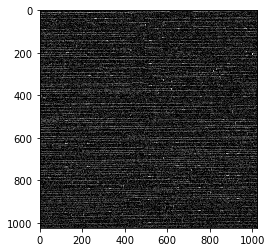

[+] StructureTensor orientation image:


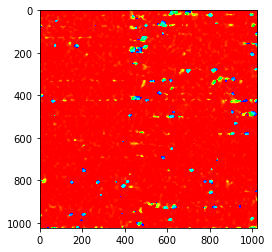

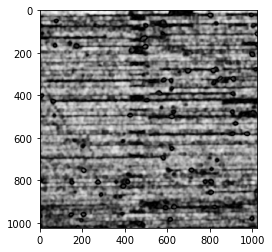

[+] Thershold image:


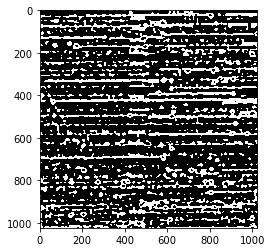

Ones 274387 Zeros 774189 Percent 73.83241653442383% 1
[1] Classification --> On image is metal <--


In [6]:
image = images[2]
img = image['img']
dip.Image(img).Show()
img = white_tophat(img, 7) # Applied white tophat transformation

cls_th = classify_image(img, tensor_sigma=5, method="TH", method_param=method_params['TH'], verbose=True)[0] # Thresholding based method


### Cutting image into images of 128x128 pixels

In [10]:
images_set = images
true_values = []
prediction = []

# Param for monotony based method
method_param_rl = {"gaussian_sigma": 47}

# Prediction on every image
for image in images_set:
    img = image['img']
    img = white_tophat(img, 7) # Applied white tophat transformation

    cls_result = classify_image_part(img, height=128, width=128, tensor_sigma=5, method='RL', method_param=method_param_rl, verbose=False) # monotony based method

    # Aggregate result in classification
    sum_cls = sum(x[list(x.keys())[0]] for x in cls_result)
    # If classify more than 11 small images...
    cls = 1 if sum_cls >= 11 else 0

    prediction.append(cls)
    true_values.append(1 if image['Y'] > 0 else 0)

# Print result of classification, print metrics of classification
print(prediction)
print('prediction', accuracy_score(true_values, prediction_rl), f1_score(true_values, prediction_rl), precision_score(true_values, prediction_th), recall_score(true_values, prediction_th))

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0]
prediction 0.9761904761904762 0.975609756097561 1.0 1.0


# .